In [1]:
'''
pip install trimesh rtree numpy scipy networkx tensorflow
'''

'\npip install trimesh rtree numpy scipy networkx tensorflow\n'

In [ ]:
'''
TensorFlow和PyTorch会自动检测和使用可用的GPU。
'''

import tensorflow as tf

# 检查是否有GPU可用
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# PyTorch的对应指令是torch.cuda.is_available()

In [6]:
# 开启交互旋转
%matplotlib notebook

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.7694 - loss: 0.6645 - val_accuracy: 0.9003 - val_loss: 0.3803 - learning_rate: 1.0000e-05
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.8941 - loss: 0.3524 - val_accuracy: 0.9003 - val_loss: 0.2662 - learning_rate: 1.0000e-05
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.8965 - loss: 0.2445 - val_accuracy: 0.9166 - val_loss: 0.1688 - learning_rate: 1.0000e-05
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.9195 - loss: 0.1670 - val_accuracy: 0.9237 - val_loss: 0.1567 - learning_rate: 1.0000e-05
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.9256 - loss: 0.1561 - val_accuracy: 0.9281 - val_loss: 0.1515 - learning_rate: 1.0000e-05
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.9299 - loss: 0.1501 - val_accuracy: 0.9315 - val_loss: 0.1464 - learning_rate: 1.0000e-05
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.9340 

<IPython.core.display.Javascript object>


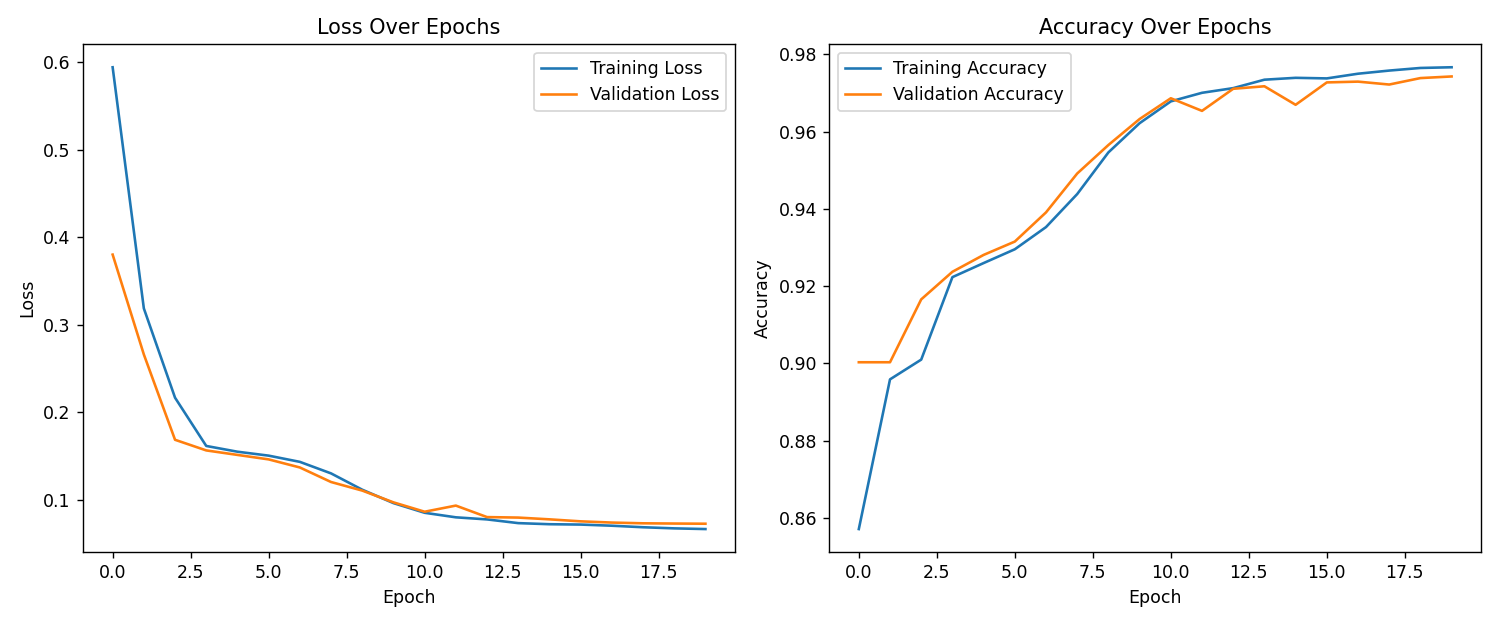

In [3]:
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 读取点云数据和标签
def load_labeled_point_cloud(file_path):
    data = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 4:
                x, y, z, label = map(float, parts)
                data.append([x, y, z])
                labels.append(int(label))
    return np.array(data), np.array(labels)

def create_voxel_grid(data, labels, grid_size, voxel_size):
    if data.size == 0 or labels.size == 0:
        print(f"Warning: Empty data or labels array. data.size={data.size}, labels.size={labels.size}")
        return None, None

    grid = np.zeros((grid_size, grid_size, grid_size))
    label_grid = np.zeros((grid_size, grid_size, grid_size))

    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1
        label_grid[voxel[0], voxel[1], voxel[2]] = labels[i] - 1  # Convert labels 1 and 2 to 0 and 1

    return grid, label_grid

def load_data_from_directory(data_dir, grid_size=32):
    x_data = []
    y_data = []
    for file in os.listdir(data_dir):
        if file.endswith("_labeled.txt"):
            file_path = os.path.join(data_dir, file)
            data, labels = load_labeled_point_cloud(file_path)
            if data.size == 0 or labels.size == 0:
                print(f"Skipping empty file: {file_path}")
                continue
            voxel_grid, label_grid = create_voxel_grid(data, labels, grid_size, grid_size)
            if voxel_grid is not None and label_grid is not None:
                x_data.append(voxel_grid)
                y_data.append(label_grid)
    x_data = np.expand_dims(np.array(x_data), axis=-1)
    y_data = np.expand_dims(np.array(y_data), axis=-1)
    return x_data, y_data

# 定义UNET模型
def unet_3d(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Bottleneck
    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder
    up5 = tf.keras.layers.Conv3DTranspose(256, 2, strides=(2, 2, 2), padding='same')(conv4)
    concat5 = tf.keras.layers.concatenate([up5, conv3], axis=-1)
    conv5 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same')(concat5)
    conv5 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.Conv3DTranspose(128, 2, strides=(2, 2, 2), padding='same')(conv5)
    concat6 = tf.keras.layers.concatenate([up6, conv2], axis=-1)
    conv6 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same')(concat6)
    conv6 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.Conv3DTranspose(64, 2, strides=(2, 2, 2), padding='same')(conv6)
    concat7 = tf.keras.layers.concatenate([up7, conv1], axis=-1)
    conv7 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same')(concat7)
    conv7 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same')(conv7)

    outputs = tf.keras.layers.Conv3D(1, 1, activation='sigmoid')(conv7)  # 1 channel output for binary classification

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

# 定义学习率调度函数
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1).numpy())

# 加载数据
data_dir = 'D:/李娅宁/肩台外侧点-0715/预处理后的数据'
x_data, y_data = load_data_from_directory(data_dir, grid_size=16)

# 确保数据归一化
x_data = x_data / np.max(x_data)
y_data = y_data / np.max(y_data)

# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

# 定义模型
input_shape = (16, 16, 16, 1)
model = unet_3d(input_shape)

# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# 定义学习率调度回调
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# 训练模型
history = model.fit(
    x_train, y_train, 
    validation_split=0.1,  # 留出一部分数据作为验证集
    epochs=20, 
    batch_size=10,
    callbacks=[lr_scheduler]
)

# 评估模型
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 绘制训练过程中的损失和精确度
def plot_training_history(history):
    """
    绘制训练过程中的损失和精确度。
    """
    # 绘制损失
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # 绘制精确度
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 使用示例：
plot_training_history(history)


In [ ]:
import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 读取点云数据和标签
def load_labeled_point_cloud(file_path):
    data = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 4:
                x, y, z, label = map(float, parts)
                data.append([x, y, z])
                labels.append(int(label))
    return np.array(data), np.array(labels)

def create_voxel_grid(data, labels, grid_size, voxel_size):
    if data.size == 0 or labels.size == 0:
        print(f"Warning: Empty data or labels array. data.size={data.size}, labels.size={labels.size}")
        return None, None

    grid = np.zeros((grid_size, grid_size, grid_size))
    label_grid = np.zeros((grid_size, grid_size, grid_size))

    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1
        label_grid[voxel[0], voxel[1], voxel[2]] = labels[i] - 1  # Convert labels 1 and 2 to 0 and 1

    return grid, label_grid

def load_data_from_directory(data_dir, grid_size=32):
    x_data = []
    y_data = []
    for file in os.listdir(data_dir):
        if file.endswith("_labeled.txt"):
            file_path = os.path.join(data_dir, file)
            data, labels = load_labeled_point_cloud(file_path)
            if data.size == 0 or labels.size == 0:
                print(f"Skipping empty file: {file_path}")
                continue
            voxel_grid, label_grid = create_voxel_grid(data, labels, grid_size, grid_size)
            if voxel_grid is not None and label_grid is not None:
                # 应用数据增强
                voxel_grid = augment_voxel_grid(voxel_grid)
                x_data.append(voxel_grid)
                y_data.append(label_grid)
    x_data = np.expand_dims(np.array(x_data), axis=-1)
    y_data = np.expand_dims(np.array(y_data), axis=-1)
    return x_data, y_data

# 数据增强
def augment_voxel_grid(voxel_grid):
    """
    对体素网格进行随机旋转和翻转。
    """
    # 随机旋转
    angle = np.random.uniform(0, 360)
    voxel_grid = np.rot90(voxel_grid, k=int(angle // 90), axes=(0, 1))
    
    # 随机翻转
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=0)
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=1)
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=2)
    
    return voxel_grid

# 定义UNET模型
def unet_3d(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv1)
    pool1 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool1)
    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv2)
    pool2 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool2)
    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv3)
    pool3 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Bottleneck
    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool3)
    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv4)

    # Decoder
    up5 = tf.keras.layers.Conv3DTranspose(256, 2, strides=(2, 2, 2), padding='same')(conv4)
    concat5 = tf.keras.layers.concatenate([up5, conv3], axis=-1)
    conv5 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat5)
    conv5 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv5)

    up6 = tf.keras.layers.Conv3DTranspose(128, 2, strides=(2, 2, 2), padding='same')(conv5)
    concat6 = tf.keras.layers.concatenate([up6, conv2], axis=-1)
    conv6 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat6)
    conv6 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv6)

    up7 = tf.keras.layers.Conv3DTranspose(64, 2, strides=(2, 2, 2), padding='same')(conv6)
    concat7 = tf.keras.layers.concatenate([up7, conv1], axis=-1)
    conv7 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat7)
    conv7 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv7)

    outputs = tf.keras.layers.Conv3D(1, 1, activation='sigmoid')(conv7)  # 1 channel output for binary classification

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

# 定义学习率调度函数
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1).numpy())

# 加载数据
data_dir = 'D:/李娅宁/肩台外侧点-0715/预处理后的数据'
x_data, y_data = load_data_from_directory(data_dir, grid_size=16)

# 确保数据归一化
x_data = x_data / np.max(x_data)
y_data = y_data / np.max(y_data)

# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

# 定义模型
input_shape = (16, 16, 16, 1)
model = unet_3d(input_shape)

# 编译模型
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# 定义学习率调度回调和早停回调
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 训练模型
history = model.fit(
    x_train, y_train, 
    validation_split=0.1,
    epochs=5, 
    batch_size=10,
    callbacks=[lr_scheduler, early_stopping]
)

# 评估模型
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 绘制训练过程中的损失和精确度
def plot_training_history(history):
    """
    绘制训练过程中的损失和精确度。
    """
    # 绘制损失
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # 绘制精确度
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 使用示例：
plot_training_history(history)


In [ ]:
'''
预训练，其结果决定下一个cell采用的Batch size。结果发现影响不大，32及以上会让学习曲线出现阶梯状，以后取B = 10。
其他参数炒过了：学习率（手动实验0.0001，0.00001等）、训练轮数（设置早停）、网络结构超参数（参照常规）
结果是，学习率0.00003下，2轮达到几乎最高精确度，也就是还得调小。
'''

import numpy as np
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 读取点云数据和标签
def load_labeled_point_cloud(file_path):
    data = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 4:
                x, y, z, label = map(float, parts)
                data.append([x, y, z])
                labels.append(int(label))
    return np.array(data), np.array(labels)

def create_voxel_grid(data, labels, grid_size, voxel_size):
    if data.size == 0 or labels.size == 0:
        print(f"Warning: Empty data or labels array. data.size={data.size}, labels.size={labels.size}")
        return None, None

    grid = np.zeros((grid_size, grid_size, grid_size))
    label_grid = np.zeros((grid_size, grid_size, grid_size))

    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1
        label_grid[voxel[0], voxel[1], voxel[2]] = labels[i] - 1  # Convert labels 1 and 2 to 0 and 1

    return grid, label_grid

def load_data_from_directory(data_dir, grid_size=32):
    x_data = []
    y_data = []
    for file in os.listdir(data_dir):
        if file.endswith("_labeled.txt"):
            file_path = os.path.join(data_dir, file)
            data, labels = load_labeled_point_cloud(file_path)
            if data.size == 0 or labels.size == 0:
                print(f"Skipping empty file: {file_path}")
                continue
            voxel_grid, label_grid = create_voxel_grid(data, labels, grid_size, grid_size)
            if voxel_grid is not None and label_grid is not None:
                # 应用数据增强
                voxel_grid = augment_voxel_grid(voxel_grid)
                x_data.append(voxel_grid)
                y_data.append(label_grid)
    x_data = np.expand_dims(np.array(x_data), axis=-1)
    y_data = np.expand_dims(np.array(y_data), axis=-1)
    return x_data, y_data

# 数据增强
def augment_voxel_grid(voxel_grid):
    """
    对体素网格进行随机旋转和翻转。
    """
    # 随机旋转
    angle = np.random.uniform(0, 360)
    voxel_grid = np.rot90(voxel_grid, k=int(angle // 90), axes=(0, 1))
    
    # 随机翻转
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=0)
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=1)
    if np.random.rand() > 0.5:
        voxel_grid = np.flip(voxel_grid, axis=2)
    
    return voxel_grid

# 定义UNET模型
def unet_3d(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
    conv1 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv1)
    pool1 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool1)
    conv2 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv2)
    pool2 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool2)
    conv3 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv3)
    pool3 = tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Bottleneck
    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(pool3)
    conv4 = tf.keras.layers.Conv3D(512, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv4)

    # Decoder
    up5 = tf.keras.layers.Conv3DTranspose(256, 2, strides=(2, 2, 2), padding='same')(conv4)
    concat5 = tf.keras.layers.concatenate([up5, conv3], axis=-1)
    conv5 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat5)
    conv5 = tf.keras.layers.Conv3D(256, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv5)

    up6 = tf.keras.layers.Conv3DTranspose(128, 2, strides=(2, 2, 2), padding='same')(conv5)
    concat6 = tf.keras.layers.concatenate([up6, conv2], axis=-1)
    conv6 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat6)
    conv6 = tf.keras.layers.Conv3D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv6)

    up7 = tf.keras.layers.Conv3DTranspose(64, 2, strides=(2, 2, 2), padding='same')(conv6)
    concat7 = tf.keras.layers.concatenate([up7, conv1], axis=-1)
    conv7 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(concat7)
    conv7 = tf.keras.layers.Conv3D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(conv7)

    outputs = tf.keras.layers.Conv3D(1, 1, activation='sigmoid')(conv7)  # 1 channel output for binary classification

    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

# 定义学习率调度函数
def scheduler(epoch, lr):
    if epoch < 10:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1).numpy())

# 加载数据
data_dir = 'D:/李娅宁/肩台外侧点-0715/预处理后的数据'
x_data, y_data = load_data_from_directory(data_dir, grid_size=16)

# 确保数据归一化
x_data = x_data / np.max(x_data)
y_data = y_data / np.max(y_data)

# 划分数据集
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

# 定义批次大小的候选值
batch_sizes = [8, 16, 32, 64]

for batch_size in batch_sizes:
    print(f"Testing batch size: {batch_size}")
    
    # 定义模型
    input_shape = (16, 16, 16, 1)
    model = unet_3d(input_shape)

    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    # 定义学习率调度回调和早停回调
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # 训练模型
    history = model.fit(
        x_train, y_train, 
        validation_split=0.1,
        epochs=20, 
        batch_size=batch_size,
        callbacks=[lr_scheduler, early_stopping]
    )

    # 评估模型
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    print(f"Batch Size: {batch_size}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

    # 绘制训练过程中的损失和精确度
    def plot_training_history(history):
        """
        绘制训练过程中的损失和精确度。
        """
        plt.figure(figsize=(12, 5))

        # 绘制损失
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Over Epochs')
        plt.legend()

        # 绘制精确度
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()

    plot_training_history(history)


In [4]:
# 保存模型
model_save_path = 'D:/李娅宁/肩台外侧点-0715/unet_3d_model.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# 加载模型
model_load_path = 'D:/李娅宁/肩台外侧点-0715/unet_3d_model.h5'
loaded_model = tf.keras.models.load_model(model_load_path)
print(f"Model loaded from {model_load_path}")


Model saved to D:/李娅宁/肩台外侧点-0715/unet_3d_model.h5


Model loaded from D:/李娅宁/肩台外侧点-0715/unet_3d_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


<IPython.core.display.Javascript object>


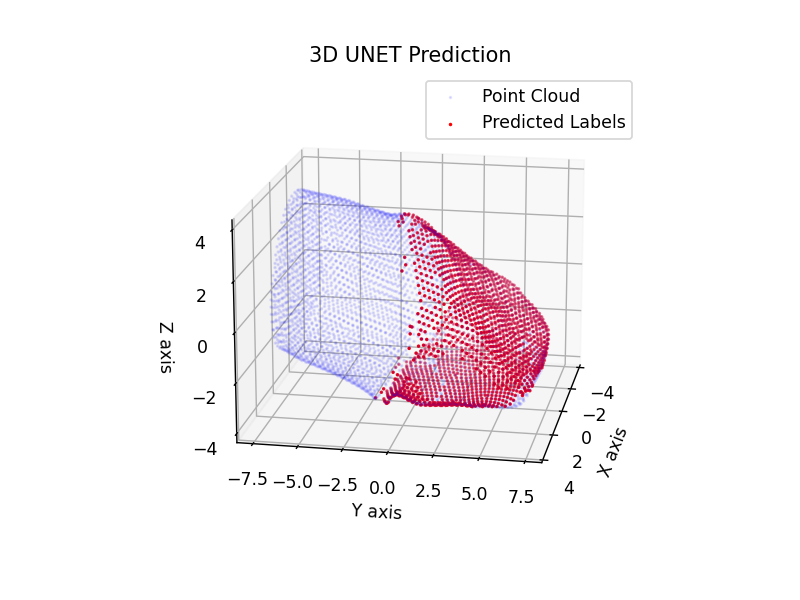

In [19]:
# txt版预测，输出是散点
# 分类显示有问题，这里显示的是全部&牙冠，而非牙根&牙冠，后续版本会改正

import matplotlib.pyplot as plt
import numpy as np

def voxelize_point_cloud(data, voxel_size, grid_size):
    """
    将点云体素化并返回体素网格和体素索引。
    """
    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size
    
    voxel_indices = np.floor((data - min_coords) / voxel_dim).astype(int)
    voxel_indices = np.clip(voxel_indices, 0, grid_size-1)
    
    return voxel_indices

def map_voxel_predictions_to_point_cloud(voxel_grid, voxel_indices):
    """
    将体素网格的预测映射到原始点云的坐标。
    """
    voxel_size = 1.0 / voxel_grid.shape[0]
    min_coords = np.min(voxel_indices, axis=0) * voxel_size
    max_coords = np.max(voxel_indices, axis=0) * voxel_size
    voxel_dim = (max_coords - min_coords) / voxel_grid.shape[0]
    
    points = voxel_indices * voxel_dim + min_coords + voxel_dim / 2
    return points

def plot_predicted_surface(original_data, predicted_labels, threshold=0.5):
    """
    可视化点云和预测结果。
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 原始点云
    ax.scatter(original_data[:, 0], original_data[:, 1], original_data[:, 2], c='blue', s=1, alpha=0.1, label='Point Cloud')

    # 预测标签
    pred_indices = np.where(predicted_labels.flatten() > threshold)[0]
    pred_points = original_data[pred_indices]
    
    ax.scatter(pred_points[:, 0], pred_points[:, 1], pred_points[:, 2], c='red', s=1, label='Predicted Labels')

    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D UNET Prediction')

    # 添加图例
    ax.legend()
    plt.show()

def visualize_sample(model, data_path, voxel_size=16, grid_size=16):
    """
    可视化一个样本的预测结果。
    """
    # 加载并体素化点云数据
    original_data, _ = load_labeled_point_cloud(data_path)
    voxel_indices = voxelize_point_cloud(original_data, voxel_size, grid_size)

    # 创建体素网格
    voxel_grid = np.zeros((grid_size, grid_size, grid_size))
    voxel_grid[tuple(voxel_indices.T)] = 1
    
    # 进行预测
    voxel_grid = np.expand_dims(voxel_grid, axis=(0, -1))  # 增加batch和channel维度
    y_pred = model.predict(voxel_grid)[0]

    # 映射预测结果到点云空间
    predicted_labels = np.zeros(len(original_data))
    for i, voxel_index in enumerate(voxel_indices):
        predicted_labels[i] = y_pred[voxel_index[0], voxel_index[1], voxel_index[2]]
    
    # 可视化结果
    plot_predicted_surface(original_data, predicted_labels, threshold=0.5)

# 示例调用
visualize_sample(model, 'D:/李娅宁/肩台外侧点-0715/预处理后的数据/7_10_labeled.txt', voxel_size=16, grid_size=16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


<IPython.core.display.Javascript object>


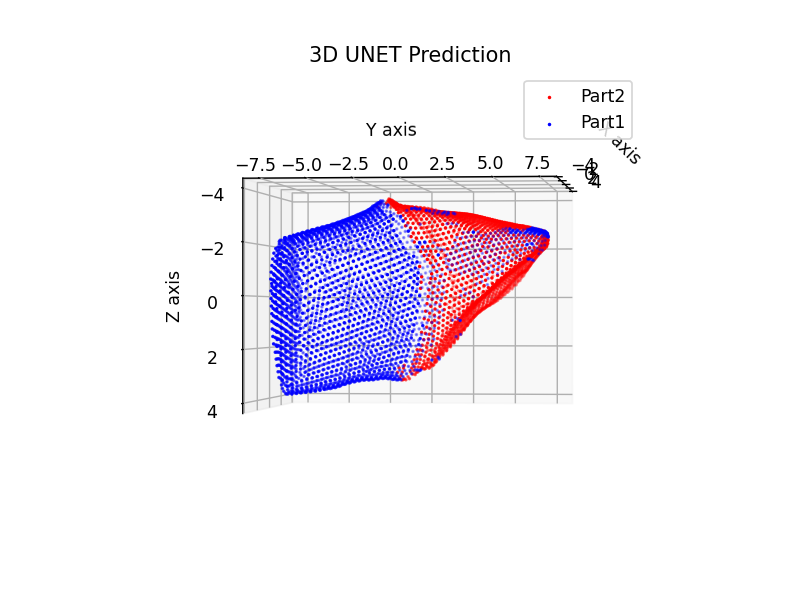

In [22]:
# obj版预测，输出是散点
# 显示二分类

import matplotlib.pyplot as plt
import numpy as np

def voxelize_point_cloud(data, voxel_size, grid_size):
    """
    将点云体素化并返回体素网格和体素索引。
    """
    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size
    
    voxel_indices = np.floor((data - min_coords) / voxel_dim).astype(int)
    voxel_indices = np.clip(voxel_indices, 0, grid_size-1)
    
    return voxel_indices

def map_voxel_predictions_to_point_cloud(voxel_grid, voxel_indices):
    """
    将体素网格的预测映射到原始点云的坐标。
    """
    voxel_size = 1.0 / voxel_grid.shape[0]
    min_coords = np.min(voxel_indices, axis=0) * voxel_size
    max_coords = np.max(voxel_indices, axis=0) * voxel_size
    voxel_dim = (max_coords - min_coords) / voxel_grid.shape[0]
    
    points = voxel_indices * voxel_dim + min_coords + voxel_dim / 2
    return points

def plot_predicted_surface(original_data, predicted_labels, threshold=0.5):
    """
    可视化预测结果。过阈值的点和未过阈值的点用不同颜色显示。
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 预测标签大于阈值的点
    part2_indices = np.where(predicted_labels > threshold)[0]
    part2_points = original_data[part2_indices]
    ax.scatter(part2_points[:, 0], part2_points[:, 1], part2_points[:, 2], c='red', s=1, label='Part2')

    # 预测标签小于或等于阈值的点
    part1_indices = np.where(predicted_labels <= threshold)[0]
    part1_points = original_data[part1_indices]
    ax.scatter(part1_points[:, 0], part1_points[:, 1], part1_points[:, 2], c='blue', s=1, label='Part1')

    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D UNET Prediction')

    # 添加图例
    ax.legend()
    plt.show()

def visualize_sample(model, data_path, voxel_size=16, grid_size=16):
    """
    可视化一个样本的预测结果。
    """
    # 加载并体素化点云数据
    original_data, _ = load_labeled_point_cloud(data_path)
    voxel_indices = voxelize_point_cloud(original_data, voxel_size, grid_size)

    # 创建体素网格
    voxel_grid = np.zeros((grid_size, grid_size, grid_size))
    voxel_grid[tuple(voxel_indices.T)] = 1
    
    # 进行预测
    voxel_grid = np.expand_dims(voxel_grid, axis=(0, -1))  # 增加batch和channel维度
    y_pred = model.predict(voxel_grid)[0]

    # 映射预测结果到点云空间
    predicted_labels = np.zeros(len(original_data))
    for i, voxel_index in enumerate(voxel_indices):
        predicted_labels[i] = y_pred[voxel_index[0], voxel_index[1], voxel_index[2]]
    
    # 可视化结果
    plot_predicted_surface(original_data, predicted_labels, threshold=0.5)

# 示例调用
visualize_sample(model, 'D:/李娅宁/肩台外侧点-0715/预处理后的数据/7_10_labeled.txt', voxel_size=16, grid_size=16)


Model input shape: (None, 16, 16, 16, 1)
Voxel grid shape: (1, 16, 16, 16, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


<IPython.core.display.Javascript object>


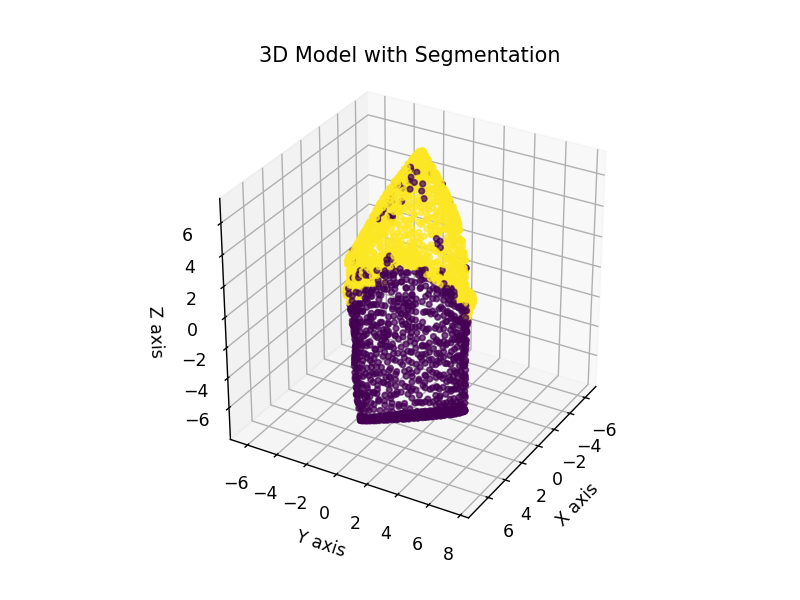

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf

# 加载obj文件
def load_obj_file(file_path):
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return vertices, faces

# 将顶点平移至包围盒中心
def center_vertices(vertices):
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices.tolist()

# 点云转体素网格
def create_voxel_grid(data, grid_size):
    grid = np.zeros((grid_size, grid_size, grid_size))
    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1

    return grid, min_coords, voxel_dim

# 旋转点云
def rotate_points(points, angles):
    x_angle, y_angle, z_angle = angles
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x_angle), -np.sin(x_angle)],
        [0, np.sin(x_angle), np.cos(x_angle)]
    ])
    Ry = np.array([
        [np.cos(y_angle), 0, np.sin(y_angle)],
        [0, 1, 0],
        [-np.sin(y_angle), 0, np.cos(y_angle)]
    ])
    Rz = np.array([
        [np.cos(z_angle), -np.sin(z_angle), 0],
        [np.sin(z_angle), np.cos(z_angle), 0],
        [0, 0, 1]
    ])
    R = Rz @ Ry @ Rx
    return points @ R.T

# 绘制带有分类标签的点云
def plot_surface_with_marks(vertices, faces, labels, angles=(0, 0, 0)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    vertices = np.array(vertices)
    faces = np.array(faces)

    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    x, y, z = vertices.T

    try:
        # 标记分割的点云部分
        part1_faces = [face for face in faces if set(face) & set(labels[labels == 0])]
        part2_faces = [face for face in faces if set(face) & set(labels[labels == 1])]
        
        part1_faces = np.array(part1_faces)
        part2_faces = np.array(part2_faces)
        
        if len(part1_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part1_faces, color='cornflowerblue', alpha=0.6)
        if len(part2_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part2_faces, color='honeydew', alpha=0.6)

    except ValueError as e:
        print(f"ValueError: {e}")
        return

    # 绘制点云标记
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=labels, cmap='viridis', s=10, alpha=0.7)

    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Segmentation')

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    ax.view_init(elev=30, azim=30)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()

# 从训练好的模型获取标签
def get_labels_from_model(model, voxel_grid):
    voxel_grid = np.expand_dims(voxel_grid, axis=0)  # Add batch dimension
    voxel_grid = np.expand_dims(voxel_grid, axis=-1)  # Add channel dimension
    print(f"Model input shape: {model.input_shape}")
    print(f"Voxel grid shape: {voxel_grid.shape}")
    predictions = model.predict(voxel_grid)
    labels = (predictions > 0.5).astype(int)
    return labels.reshape(voxel_grid.shape[1], voxel_grid.shape[2], voxel_grid.shape[3])

# 加载点云数据
obj_file_path = r'D:/李娅宁/肩台外侧点-0715/已完成预处理的原始数据/150颗/60.obj'
vertices, faces = load_obj_file(obj_file_path)
centered_vertices = center_vertices(vertices)

# 将点云转换为体素网格
grid_size = 16  # Ensure grid size matches model requirements
voxel_grid, min_coords, voxel_dim = create_voxel_grid(np.array(centered_vertices), grid_size)

# 使用训练好的模型进行预测
predicted_labels = get_labels_from_model(model, voxel_grid)

# 应用预测标签到原始点云
def apply_labels_to_point_cloud(data, predicted_labels, min_coords, voxel_dim, grid_size):
    labels = np.zeros(len(data))
    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        labels[i] = predicted_labels[voxel[0], voxel[1], voxel[2]]
    return labels

# 获取原始点云的预测标签
predicted_point_labels = apply_labels_to_point_cloud(np.array(centered_vertices), predicted_labels, min_coords, voxel_dim, grid_size)

# 定义分割的部分（需要根据实际情况定义）
part1 = set()  # Replace with actual set of indices for part 1
part2 = set()  # Replace with actual set of indices for part 2

# 调整视角 (angles in radians)
plot_surface_with_marks(centered_vertices, faces, predicted_point_labels, angles=(np.radians(90), np.radians(-30), np.radians(30)))


Model input shape: (None, 16, 16, 16, 1)
Voxel grid shape: (1, 16, 16, 16, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


<IPython.core.display.Javascript object>


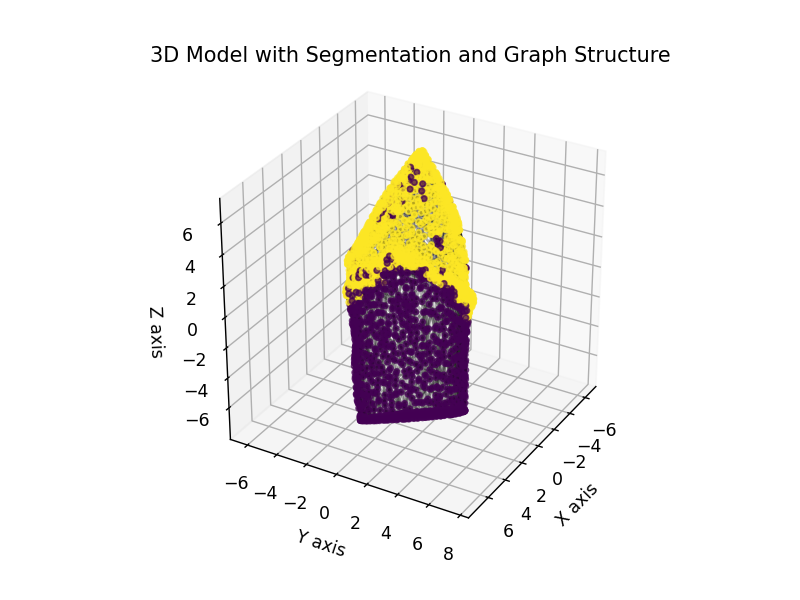

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import networkx as nx


# 加载obj文件
def load_obj_file(file_path):
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return vertices, faces

# 将顶点平移至包围盒中心
def center_vertices(vertices):
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices.tolist()

# 点云转体素网格
def create_voxel_grid(data, grid_size):
    grid = np.zeros((grid_size, grid_size, grid_size))
    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1

    return grid, min_coords, voxel_dim

# 旋转点云
def rotate_points(points, angles):
    x_angle, y_angle, z_angle = angles
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x_angle), -np.sin(x_angle)],
        [0, np.sin(x_angle), np.cos(x_angle)]
    ])
    Ry = np.array([
        [np.cos(y_angle), 0, np.sin(y_angle)],
        [0, 1, 0],
        [-np.sin(y_angle), 0, np.cos(y_angle)]
    ])
    Rz = np.array([
        [np.cos(z_angle), -np.sin(z_angle), 0],
        [np.sin(z_angle), np.cos(z_angle), 0],
        [0, 0, 1]
    ])
    R = Rz @ Ry @ Rx
    return points @ R.T

# 生成拓扑图
def generate_graph(vertices, faces):
    G = nx.Graph()
    for i, vertex in enumerate(vertices):
        G.add_node(i, pos=vertex)
    for face in faces:
        for i in range(len(face)):
            G.add_edge(face[i], face[(i+1) % len(face)])
    return G

# 绘制带有分类标签的点云
def plot_surface_with_marks(vertices, faces, labels, angles=(0, 0, 0)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    vertices = np.array(vertices)
    faces = np.array(faces)

    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    x, y, z = vertices.T

    try:
        # 标记分割的点云部分
        part1_faces = [face for face in faces if set(face) & set(labels[labels == 0])]
        part2_faces = [face for face in faces if set(face) & set(labels[labels == 1])]
        
        part1_faces = np.array(part1_faces)
        part2_faces = np.array(part2_faces)
        
        if len(part1_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part1_faces, color='cornflowerblue', alpha=0.6)
        if len(part2_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part2_faces, color='honeydew', alpha=0.6)

    except ValueError as e:
        print(f"ValueError: {e}")
        return

    # 绘制点云标记
    ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=labels, cmap='viridis', s=10, alpha=0.7)

    # 生成图结构并绘制边
    G = generate_graph(vertices, faces)
    pos = nx.get_node_attributes(G, 'pos')
    edges = G.edges()
    for edge in edges:
        x_values = [pos[edge[0]][0], pos[edge[1]][0]]
        y_values = [pos[edge[0]][1], pos[edge[1]][1]]
        z_values = [pos[edge[0]][2], pos[edge[1]][2]]
        ax.plot(x_values, y_values, z_values, color='black', alpha=0.3)

    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Segmentation and Graph Structure')

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    ax.view_init(elev=30, azim=30)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()

# 从训练好的模型获取标签
def get_labels_from_model(model, voxel_grid):
    voxel_grid = np.expand_dims(voxel_grid, axis=0)  # Add batch dimension
    voxel_grid = np.expand_dims(voxel_grid, axis=-1)  # Add channel dimension
    print(f"Model input shape: {model.input_shape}")
    print(f"Voxel grid shape: {voxel_grid.shape}")
    predictions = model.predict(voxel_grid)
    labels = (predictions > 0.5).astype(int)
    return labels.reshape(voxel_grid.shape[1], voxel_grid.shape[2], voxel_grid.shape[3])

# 加载点云数据
obj_file_path = r'D:/李娅宁/肩台外侧点-0715/已完成预处理的原始数据/150颗/60.obj'
vertices, faces = load_obj_file(obj_file_path)
centered_vertices = center_vertices(vertices)

# 将点云转换为体素网格
grid_size = 16  # Ensure grid size matches model requirements
voxel_grid, min_coords, voxel_dim = create_voxel_grid(np.array(centered_vertices), grid_size)

# 使用训练好的模型进行预测
predicted_labels = get_labels_from_model(model, voxel_grid)

# 应用预测标签到原始点云
def apply_labels_to_point_cloud(data, predicted_labels, min_coords, voxel_dim, grid_size):
    labels = np.zeros(len(data))
    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        labels[i] = predicted_labels[voxel[0], voxel[1], voxel[2]]
    return labels

# 获取原始点云的预测标签
predicted_point_labels = apply_labels_to_point_cloud(np.array(centered_vertices), predicted_labels, min_coords, voxel_dim, grid_size)

# 定义分割的部分（需要根据实际情况定义）
part1 = set()  # Replace with actual set of indices for part 1
part2 = set()  # Replace with actual set of indices for part 2

# 调整视角 (angles in radians)
plot_surface_with_marks(centered_vertices, faces, predicted_point_labels, angles=(np.radians(90), np.radians(-30), np.radians(30)))


Model input shape: (None, 16, 16, 16, 1)
Voxel grid shape: (1, 16, 16, 16, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


<IPython.core.display.Javascript object>


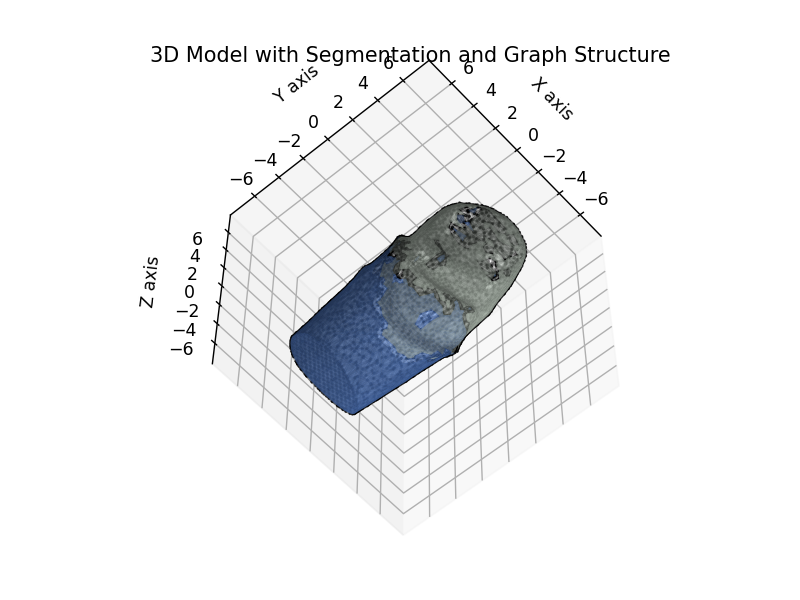

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import networkx as nx

# 加载obj文件
def load_obj_file(file_path):
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return vertices, faces

# 将顶点平移至包围盒中心
def center_vertices(vertices):
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices.tolist()

# 点云转体素网格
def create_voxel_grid(data, grid_size):
    grid = np.zeros((grid_size, grid_size, grid_size))
    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1

    return grid, min_coords, voxel_dim

# 旋转点云
def rotate_points(points, angles):
    x_angle, y_angle, z_angle = angles
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x_angle), -np.sin(x_angle)],
        [0, np.sin(x_angle), np.cos(x_angle)]
    ])
    Ry = np.array([
        [np.cos(y_angle), 0, np.sin(y_angle)],
        [0, 1, 0],
        [-np.sin(y_angle), 0, np.cos(y_angle)]
    ])
    Rz = np.array([
        [np.cos(z_angle), -np.sin(z_angle), 0],
        [np.sin(z_angle), np.cos(z_angle), 0],
        [0, 0, 1]
    ])
    R = Rz @ Ry @ Rx
    return points @ R.T

# 生成拓扑图
def generate_graph(vertices, faces):
    G = nx.Graph()
    for i, vertex in enumerate(vertices):
        G.add_node(i, pos=vertex)
    for face in faces:
        for i in range(len(face)):
            G.add_edge(face[i], face[(i+1) % len(face)])
    return G

# 绘制带有分类标签的点云
def plot_surface_with_marks(vertices, faces, labels, part1, part2, angles=(0, 0, 0)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    vertices = np.array(vertices)
    faces = np.array(faces)

    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    x, y, z = vertices.T

    try:
        # 标记分割的点云部分
        part1_faces = [face for face in faces if all(labels[vertex] == 0 for vertex in face)]
        part2_faces = [face for face in faces if all(labels[vertex] == 1 for vertex in face)]
        
        part1_faces = np.array(part1_faces)
        part2_faces = np.array(part2_faces)
        
        if len(part1_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part1_faces, color='cornflowerblue', alpha=0.6)
        if len(part2_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part2_faces, color='honeydew', alpha=0.6)

    except ValueError as e:
        print(f"ValueError: {e}")
        return

    # 生成图结构并绘制边
    G = generate_graph(vertices, faces)
    pos = nx.get_node_attributes(G, 'pos')
    edges = G.edges()
    for edge in edges:
        x_values = [pos[edge[0]][0], pos[edge[1]][0]]
        y_values = [pos[edge[0]][1], pos[edge[1]][1]]
        z_values = [pos[edge[0]][2], pos[edge[1]][2]]
        ax.plot(x_values, y_values, z_values, color='black', alpha=0.3)

    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Segmentation and Graph Structure')

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    ax.view_init(elev=30, azim=30)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()

# 从训练好的模型获取标签
def get_labels_from_model(model, voxel_grid):
    voxel_grid = np.expand_dims(voxel_grid, axis=0)  # Add batch dimension
    voxel_grid = np.expand_dims(voxel_grid, axis=-1)  # Add channel dimension
    predictions = model.predict(voxel_grid)
    labels = (predictions > 0.5).astype(int)
    return labels.reshape(voxel_grid.shape[1], voxel_grid.shape[2], voxel_grid.shape[3])

# 加载点云数据
obj_file_path = r'D:/李娅宁/肩台外侧点-0715/已完成预处理的原始数据/150颗/60.obj'
vertices, faces = load_obj_file(obj_file_path)
centered_vertices = center_vertices(vertices)

# 将点云转换为体素网格
grid_size = 16  # Ensure grid size matches model requirements
voxel_grid, min_coords, voxel_dim = create_voxel_grid(np.array(centered_vertices), grid_size)

# 使用训练好的模型进行预测
predicted_labels = get_labels_from_model(model, voxel_grid)

# 应用预测标签到原始点云
def apply_labels_to_point_cloud(data, predicted_labels, min_coords, voxel_dim, grid_size):
    labels = np.zeros(len(data))
    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        labels[i] = predicted_labels[voxel[0], voxel[1], voxel[2]]
    return labels

# 获取原始点云的预测标签
predicted_point_labels = apply_labels_to_point_cloud(np.array(centered_vertices), predicted_labels, min_coords, voxel_dim, grid_size)

# 定义分割的部分（需要根据实际情况定义）
part1 = {i for i, label in enumerate(predicted_point_labels) if label == 0}
part2 = {i for i, label in enumerate(predicted_point_labels) if label == 1}

# 调整视角 (angles in radians)
plot_surface_with_marks(centered_vertices, faces, predicted_point_labels, part1, part2)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


<IPython.core.display.Javascript object>


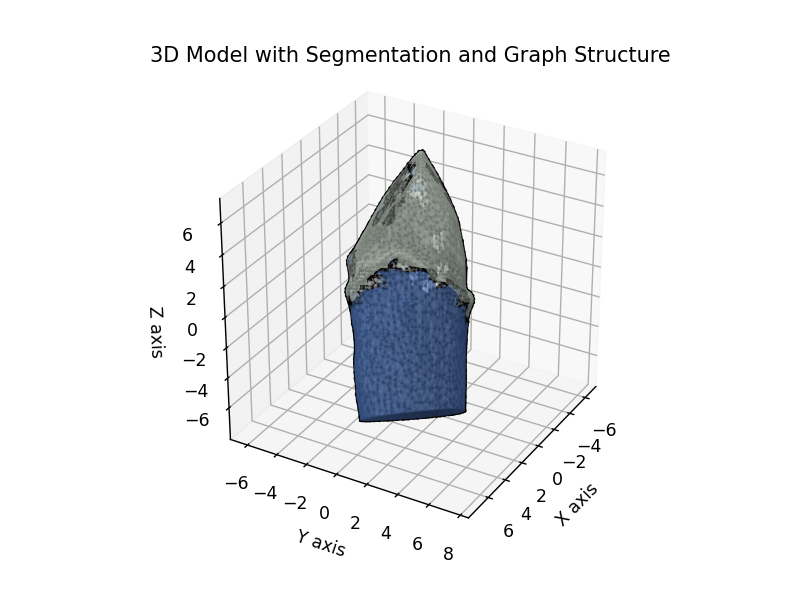

In [10]:
'''
模型用于预测，以及结果可视化
'''

# 开启交互旋转
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import networkx as nx

# 加载obj文件
def load_obj_file(file_path):
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return vertices, faces

# 将顶点平移至包围盒中心
def center_vertices(vertices):
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices.tolist()

# 点云转体素网格
def create_voxel_grid(data, grid_size):
    grid = np.zeros((grid_size, grid_size, grid_size))
    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1

    return grid, min_coords, voxel_dim

# 旋转点云
def rotate_points(points, angles):
    x_angle, y_angle, z_angle = angles
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x_angle), -np.sin(x_angle)],
        [0, np.sin(x_angle), np.cos(x_angle)]
    ])
    Ry = np.array([
        [np.cos(y_angle), 0, np.sin(y_angle)],
        [0, 1, 0],
        [-np.sin(y_angle), 0, np.cos(y_angle)]
    ])
    Rz = np.array([
        [np.cos(z_angle), -np.sin(z_angle), 0],
        [np.sin(z_angle), np.cos(z_angle), 0],
        [0, 0, 1]
    ])
    R = Rz @ Ry @ Rx
    return points @ R.T

# 生成拓扑图
def generate_graph(vertices, faces):
    G = nx.Graph()
    for i, vertex in enumerate(vertices):
        G.add_node(i, pos=vertex)
    for face in faces:
        for i in range(len(face)):
            G.add_edge(face[i], face[(i+1) % len(face)])
    return G

# 绘制带有分类标签的点云
def plot_surface_with_marks(vertices, faces, labels, part1, part2, view_angles=(30, 30), angles=(0, 0, 0)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    vertices = np.array(vertices)
    faces = np.array(faces)

    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    x, y, z = vertices.T

    try:
        # 标记分割的点云部分
        part1_faces = [face for face in faces if all(labels[vertex] == 0 for vertex in face)]
        part2_faces = [face for face in faces if all(labels[vertex] == 1 for vertex in face)]
        
        part1_faces = np.array(part1_faces)
        part2_faces = np.array(part2_faces)
        
        if len(part1_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part1_faces, color='cornflowerblue', alpha=0.6)
        if len(part2_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part2_faces, color='honeydew', alpha=0.6)

    except ValueError as e:
        print(f"ValueError: {e}")
        return

    # 生成图结构并绘制边
    G = generate_graph(vertices, faces)
    pos = nx.get_node_attributes(G, 'pos')
    edges = G.edges()
    for edge in edges:
        x_values = [pos[edge[0]][0], pos[edge[1]][0]]
        y_values = [pos[edge[0]][1], pos[edge[1]][1]]
        z_values = [pos[edge[0]][2], pos[edge[1]][2]]
        ax.plot(x_values, y_values, z_values, color='black', alpha=0.3)

    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Segmentation and Graph Structure')

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()

# 从训练好的模型获取标签
def get_labels_from_model(model, voxel_grid):
    voxel_grid = np.expand_dims(voxel_grid, axis=0)  # Add batch dimension
    voxel_grid = np.expand_dims(voxel_grid, axis=-1)  # Add channel dimension
    predictions = model.predict(voxel_grid)
    labels = (predictions > 0.5).astype(int)
    return labels.reshape(voxel_grid.shape[1], voxel_grid.shape[2], voxel_grid.shape[3])

# 加载点云数据
obj_file_path = r'D:/李娅宁/肩台外侧点-0715/已完成预处理的原始数据/150颗/60.obj'
vertices, faces = load_obj_file(obj_file_path)
centered_vertices = center_vertices(vertices)

# 将点云转换为体素网格
grid_size = 16  # Ensure grid size matches model requirements
voxel_grid, min_coords, voxel_dim = create_voxel_grid(np.array(centered_vertices), grid_size)

# 使用训练好的模型进行预测
predicted_labels = get_labels_from_model(model, voxel_grid)

# 应用预测标签到原始点云
def apply_labels_to_point_cloud(data, predicted_labels, min_coords, voxel_dim, grid_size):
    labels = np.zeros(len(data))
    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        labels[i] = predicted_labels[voxel[0], voxel[1], voxel[2]]
    return labels

# 获取原始点云的预测标签
predicted_point_labels = apply_labels_to_point_cloud(np.array(centered_vertices), predicted_labels, min_coords, voxel_dim, grid_size)

# 定义分割的部分（需要根据实际情况定义）
part1 = {i for i, label in enumerate(predicted_point_labels) if label == 0}
part2 = {i for i, label in enumerate(predicted_point_labels) if label == 1}

# 调整视角 (angles in radians)
plot_surface_with_marks(centered_vertices, faces, predicted_point_labels, part1, part2, view_angles=(30, 30), angles=(np.radians(90), np.radians(-30), np.radians(30)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


<IPython.core.display.Javascript object>


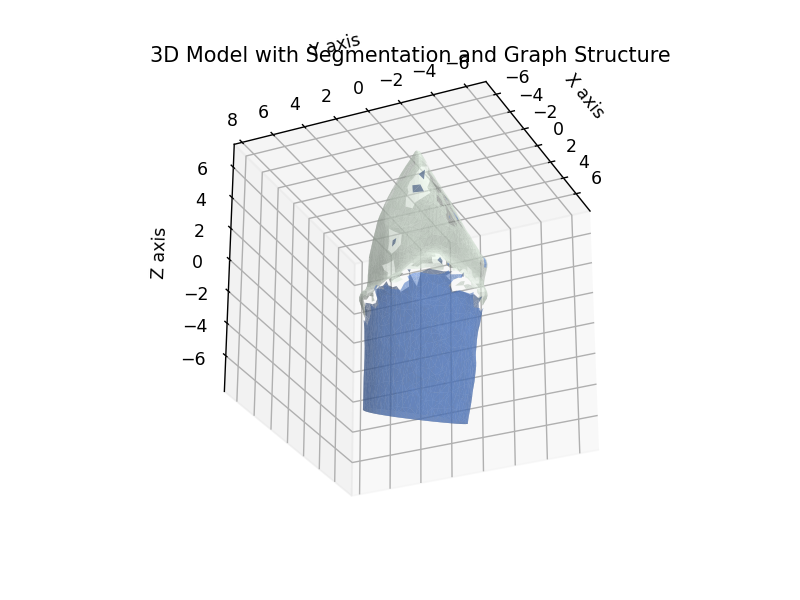

In [11]:
'''
删掉网格线，发现有洞，原因是三角面分类标签是由“一致性法”确定的，下面将要改成“投票法”。
'''

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import networkx as nx

# 加载obj文件
def load_obj_file(file_path):
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return vertices, faces

# 将顶点平移至包围盒中心
def center_vertices(vertices):
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices.tolist()

# 点云转体素网格
def create_voxel_grid(data, grid_size):
    grid = np.zeros((grid_size, grid_size, grid_size))
    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1

    return grid, min_coords, voxel_dim

# 旋转点云
def rotate_points(points, angles):
    x_angle, y_angle, z_angle = angles
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x_angle), -np.sin(x_angle)],
        [0, np.sin(x_angle), np.cos(x_angle)]
    ])
    Ry = np.array([
        [np.cos(y_angle), 0, np.sin(y_angle)],
        [0, 1, 0],
        [-np.sin(y_angle), 0, np.cos(y_angle)]
    ])
    Rz = np.array([
        [np.cos(z_angle), -np.sin(z_angle), 0],
        [np.sin(z_angle), np.cos(z_angle), 0],
        [0, 0, 1]
    ])
    R = Rz @ Ry @ Rx
    return points @ R.T



# 绘制带有分类标签的点云
def plot_surface_with_marks(vertices, faces, labels, part1, part2, view_angles=(30, 30), angles=(0, 0, 0)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    vertices = np.array(vertices)
    faces = np.array(faces)

    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    x, y, z = vertices.T

    try:
        # 标记分割的点云部分
        part1_faces = [face for face in faces if all(labels[vertex] == 0 for vertex in face)]
        part2_faces = [face for face in faces if all(labels[vertex] == 1 for vertex in face)]
        
        part1_faces = np.array(part1_faces)
        part2_faces = np.array(part2_faces)
        
        if len(part1_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part1_faces, color='cornflowerblue', alpha=0.6)
        if len(part2_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part2_faces, color='honeydew', alpha=0.6)

    except ValueError as e:
        print(f"ValueError: {e}")
        return



    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Segmentation and Graph Structure')

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()

# 从训练好的模型获取标签
def get_labels_from_model(model, voxel_grid):
    voxel_grid = np.expand_dims(voxel_grid, axis=0)  # Add batch dimension
    voxel_grid = np.expand_dims(voxel_grid, axis=-1)  # Add channel dimension
    predictions = model.predict(voxel_grid)
    labels = (predictions > 0.5).astype(int)
    return labels.reshape(voxel_grid.shape[1], voxel_grid.shape[2], voxel_grid.shape[3])

# 加载点云数据
obj_file_path = r'D:/李娅宁/肩台外侧点-0715/已完成预处理的原始数据/150颗/60.obj'
vertices, faces = load_obj_file(obj_file_path)
centered_vertices = center_vertices(vertices)

# 将点云转换为体素网格
grid_size = 16  # Ensure grid size matches model requirements
voxel_grid, min_coords, voxel_dim = create_voxel_grid(np.array(centered_vertices), grid_size)

# 使用训练好的模型进行预测
predicted_labels = get_labels_from_model(model, voxel_grid)

# 应用预测标签到原始点云
def apply_labels_to_point_cloud(data, predicted_labels, min_coords, voxel_dim, grid_size):
    labels = np.zeros(len(data))
    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        labels[i] = predicted_labels[voxel[0], voxel[1], voxel[2]]
    return labels

# 获取原始点云的预测标签
predicted_point_labels = apply_labels_to_point_cloud(np.array(centered_vertices), predicted_labels, min_coords, voxel_dim, grid_size)

# 定义分割的部分（需要根据实际情况定义）
part1 = {i for i, label in enumerate(predicted_point_labels) if label == 0}
part2 = {i for i, label in enumerate(predicted_point_labels) if label == 1}

# 调整视角 (angles in radians)
plot_surface_with_marks(centered_vertices, faces, predicted_point_labels, part1, part2, view_angles=(30, 30), angles=(np.radians(90), np.radians(-30), np.radians(30)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


<IPython.core.display.Javascript object>


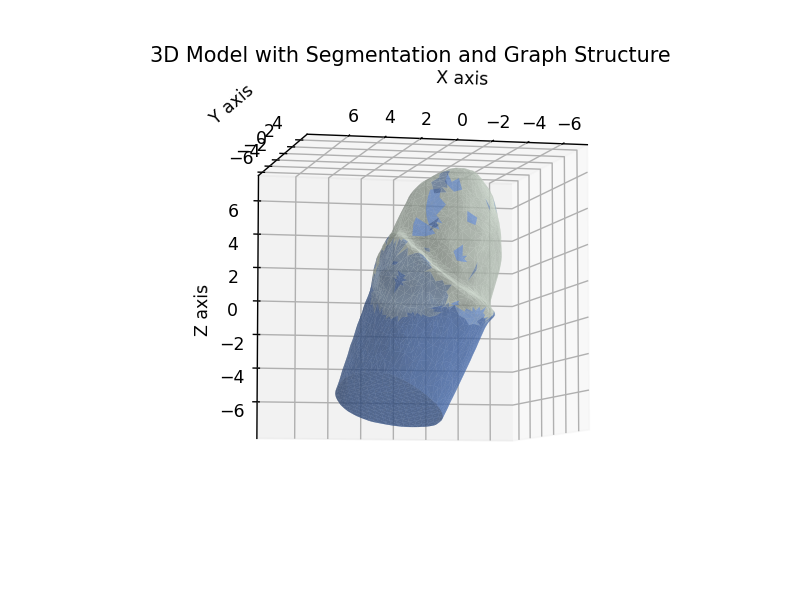

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 加载obj文件
def load_obj_file(file_path):
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return vertices, faces

# 将顶点平移至包围盒中心
def center_vertices(vertices):
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices.tolist()

# 点云转体素网格
def create_voxel_grid(data, grid_size):
    grid = np.zeros((grid_size, grid_size, grid_size))
    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1

    return grid, min_coords, voxel_dim

# 旋转点云
def rotate_points(points, angles):
    x_angle, y_angle, z_angle = angles
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x_angle), -np.sin(x_angle)],
        [0, np.sin(x_angle), np.cos(x_angle)]
    ])
    Ry = np.array([
        [np.cos(y_angle), 0, np.sin(y_angle)],
        [0, 1, 0],
        [-np.sin(y_angle), 0, np.cos(y_angle)]
    ])
    Rz = np.array([
        [np.cos(z_angle), -np.sin(z_angle), 0],
        [np.sin(z_angle), np.cos(z_angle), 0],
        [0, 0, 1]
    ])
    R = Rz @ Ry @ Rx
    return points @ R.T

# 绘制带有分类标签的点云
def plot_surface_with_marks(vertices, faces, labels, part1, part2, view_angles=(30, 30), angles=(0, 0, 0)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    vertices = np.array(vertices)
    faces = np.array(faces)

    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    x, y, z = vertices.T

    # 标记分割的点云部分
    part1_faces = []
    part2_faces = []
    
    for face in faces:
        face_labels = [labels[vertex] for vertex in face]
        if sum(face_labels) > len(face_labels) / 2:
            part2_faces.append(face)
        else:
            part1_faces.append(face)
    
    part1_faces = np.array(part1_faces)
    part2_faces = np.array(part2_faces)
    
    if len(part1_faces) > 0:
        ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part1_faces, color='cornflowerblue', alpha=0.6)
    if len(part2_faces) > 0:
        ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part2_faces, color='honeydew', alpha=0.6)

    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Segmentation and Graph Structure')

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2)
    ax.set_zlim(mid_z - max_range/2)

    # 设置视角
    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()

# 从训练好的模型获取标签
def get_labels_from_model(model, voxel_grid):
    voxel_grid = np.expand_dims(voxel_grid, axis=0)  # Add batch dimension
    voxel_grid = np.expand_dims(voxel_grid, axis=-1)  # Add channel dimension
    predictions = model.predict(voxel_grid)
    labels = (predictions > 0.5).astype(int)
    return labels.reshape(voxel_grid.shape[1], voxel_grid.shape[2], voxel_grid.shape[3])

# 加载点云数据
obj_file_path = r'D:/李娅宁/肩台外侧点-0715/已完成预处理的原始数据/150颗/60.obj'
vertices, faces = load_obj_file(obj_file_path)
centered_vertices = center_vertices(vertices)

# 将点云转换为体素网格
grid_size = 16  # Ensure grid size matches model requirements
voxel_grid, min_coords, voxel_dim = create_voxel_grid(np.array(centered_vertices), grid_size)

# 使用训练好的模型进行预测
predicted_labels = get_labels_from_model(model, voxel_grid)

# 应用预测标签到原始点云
def apply_labels_to_point_cloud(data, predicted_labels, min_coords, voxel_dim, grid_size):
    labels = np.zeros(len(data))
    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        labels[i] = predicted_labels[voxel[0], voxel[1], voxel[2]]
    return labels

# 获取原始点云的预测标签
predicted_point_labels = apply_labels_to_point_cloud(np.array(centered_vertices), predicted_labels, min_coords, voxel_dim, grid_size)

# 定义分割的部分（需要根据实际情况定义）
part1 = {i for i, label in enumerate(predicted_point_labels) if label == 0}
part2 = {i for i, label in enumerate(predicted_point_labels) if label == 1}

# 调整视角 (angles in radians)
plot_surface_with_marks(centered_vertices, faces, predicted_point_labels, part1, part2, view_angles=(30, 30), angles=(np.radians(90), np.radians(-30), np.radians(30)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


<IPython.core.display.Javascript object>


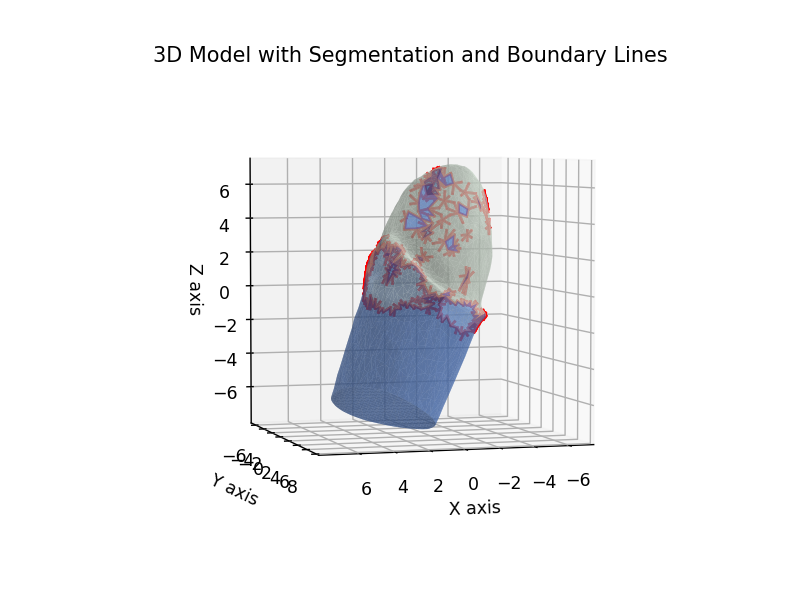

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import networkx as nx
from scipy.spatial import KDTree

# 加载obj文件
def load_obj_file(file_path):
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return vertices, faces

# 将顶点平移至包围盒中心
def center_vertices(vertices):
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices.tolist()

# 点云转体素网格
def create_voxel_grid(data, grid_size):
    grid = np.zeros((grid_size, grid_size, grid_size))
    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1

    return grid, min_coords, voxel_dim

# 旋转点云
def rotate_points(points, angles):
    x_angle, y_angle, z_angle = angles
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x_angle), -np.sin(x_angle)],
        [0, np.sin(x_angle), np.cos(x_angle)]
    ])
    Ry = np.array([
        [np.cos(y_angle), 0, np.sin(y_angle)],
        [0, 1, 0],
        [-np.sin(y_angle), 0, np.cos(y_angle)]
    ])
    Rz = np.array([
        [np.cos(z_angle), -np.sin(z_angle), 0],
        [np.sin(z_angle), np.cos(z_angle), 0],
        [0, 0, 1]
    ])
    R = Rz @ Ry @ Rx
    return points @ R.T

# 从训练好的模型获取标签
def get_labels_from_model(model, voxel_grid):
    voxel_grid = np.expand_dims(voxel_grid, axis=0)  # Add batch dimension
    voxel_grid = np.expand_dims(voxel_grid, axis=-1)  # Add channel dimension
    predictions = model.predict(voxel_grid)
    labels = (predictions > 0.5).astype(int)
    return labels.reshape(voxel_grid.shape[1], voxel_grid.shape[2], voxel_grid.shape[3])

# 应用预测标签到原始点云
def apply_labels_to_point_cloud(data, predicted_labels, min_coords, voxel_dim, grid_size):
    labels = np.zeros(len(data))
    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        labels[i] = predicted_labels[voxel[0], voxel[1], voxel[2]]
    return labels

# 绘制带有分类标签的点云和分界线
def plot_surface_with_marks(vertices, faces, labels, part1, part2, view_angles=(30, 30), angles=(0, 0, 0)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    vertices = np.array(vertices)
    faces = np.array(faces)

    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    x, y, z = vertices.T

    try:
        # 标记分割的点云部分
        part1_faces = [face for face in faces if sum(labels[vertex] == 0 for vertex in face) > 1]
        part2_faces = [face for face in faces if sum(labels[vertex] == 1 for vertex in face) > 1]
        
        part1_faces = np.array(part1_faces)
        part2_faces = np.array(part2_faces)
        
        if len(part1_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part1_faces, color='cornflowerblue', alpha=0.6)
        if len(part2_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part2_faces, color='honeydew', alpha=0.6)

        # 找到边界线
        edge_points = []
        for face in faces:
            face_labels = [labels[vertex] for vertex in face]
            if len(set(face_labels)) > 1:  # If there are mixed labels in the face
                for i in range(len(face)):
                    v1, v2 = face[i], face[(i + 1) % len(face)]
                    if labels[v1] != labels[v2]:
                        edge_points.append((vertices[v1], vertices[v2]))

        # 绘制边界线
        for (p1, p2) in edge_points:
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], color='red')

    except ValueError as e:
        print(f"ValueError: {e}")
        return

    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Segmentation and Boundary Lines')

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()

# 加载点云数据
obj_file_path = r'D:/李娅宁/肩台外侧点-0715/已完成预处理的原始数据/150颗/60.obj'
vertices, faces = load_obj_file(obj_file_path)
centered_vertices = center_vertices(vertices)

# 将点云转换为体素网格
grid_size = 16  # Ensure grid size matches model requirements
voxel_grid, min_coords, voxel_dim = create_voxel_grid(np.array(centered_vertices), grid_size)

# 使用训练好的模型进行预测
predicted_labels = get_labels_from_model(model, voxel_grid)

# 获取原始点云的预测标签
predicted_point_labels = apply_labels_to_point_cloud(np.array(centered_vertices), predicted_labels, min_coords, voxel_dim, grid_size)

# 定义分割的部分（需要根据实际情况定义）
part1 = {i for i, label in enumerate(predicted_point_labels) if label == 0}
part2 = {i for i, label in enumerate(predicted_point_labels) if label == 1}

# 调整视角 (angles in radians)
plot_surface_with_marks(centered_vertices, faces, predicted_point_labels, part1, part2, view_angles=(30, 30), angles=(np.radians(90), np.radians(-30), np.radians(30)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


<IPython.core.display.Javascript object>


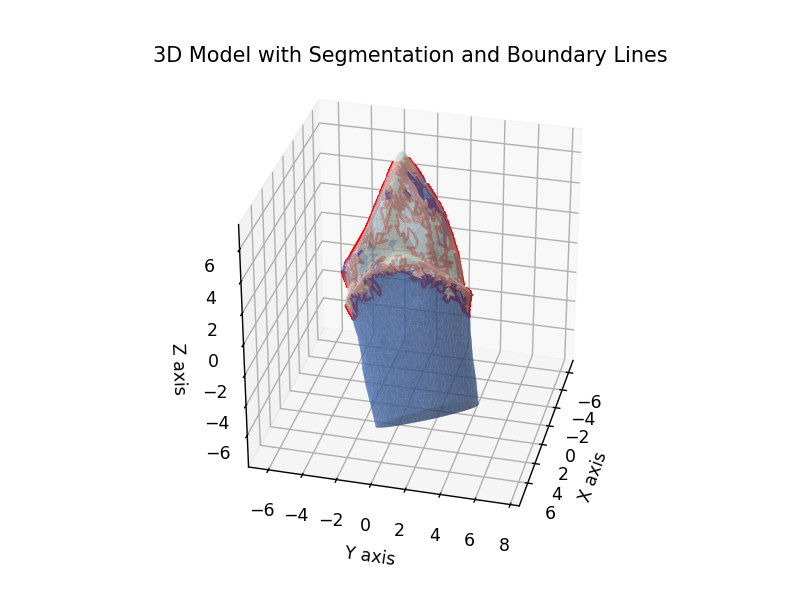

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from scipy.spatial import KDTree
from collections import defaultdict
from itertools import combinations

# 加载obj文件
def load_obj_file(file_path):
    vertices = []
    faces = []
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.startswith('v '):
                    parts = line.strip().split()
                    vertex = [float(parts[1]), float(parts[2]), float(parts[3])]
                    vertices.append(vertex)
                elif line.startswith('f '):
                    parts = line.strip().split()
                    face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                    faces.append(face)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return vertices, faces

# 将顶点平移至包围盒中心
def center_vertices(vertices):
    vertices_array = np.array(vertices)
    min_coords = vertices_array.min(axis=0)
    max_coords = vertices_array.max(axis=0)
    center = (min_coords + max_coords) / 2
    centered_vertices = vertices_array - center
    return centered_vertices.tolist()

# 点云转体素网格
def create_voxel_grid(data, grid_size):
    grid = np.zeros((grid_size, grid_size, grid_size))
    min_coords = np.min(data, axis=0)
    max_coords = np.max(data, axis=0)
    voxel_dim = (max_coords - min_coords) / grid_size

    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        grid[voxel[0], voxel[1], voxel[2]] = 1

    return grid, min_coords, voxel_dim

# 旋转点云
def rotate_points(points, angles):
    x_angle, y_angle, z_angle = angles
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x_angle), -np.sin(x_angle)],
        [0, np.sin(x_angle), np.cos(x_angle)]
    ])
    Ry = np.array([
        [np.cos(y_angle), 0, np.sin(y_angle)],
        [0, 1, 0],
        [-np.sin(y_angle), 0, np.cos(y_angle)]
    ])
    Rz = np.array([
        [np.cos(z_angle), -np.sin(z_angle), 0],
        [np.sin(z_angle), np.cos(z_angle), 0],
        [0, 0, 1]
    ])
    R = Rz @ Ry @ Rx
    return points @ R.T

# 从训练好的模型获取标签
def get_labels_from_model(model, voxel_grid):
    voxel_grid = np.expand_dims(voxel_grid, axis=0)  # Add batch dimension
    voxel_grid = np.expand_dims(voxel_grid, axis=-1)  # Add channel dimension
    predictions = model.predict(voxel_grid)
    labels = (predictions > 0.5).astype(int)
    return labels.reshape(voxel_grid.shape[1], voxel_grid.shape[2], voxel_grid.shape[3])

# 应用预测标签到原始点云
def apply_labels_to_point_cloud(data, predicted_labels, min_coords, voxel_dim, grid_size):
    labels = np.zeros(len(data))
    for i, point in enumerate(data):
        voxel = ((point - min_coords) / voxel_dim).astype(int)
        voxel = np.clip(voxel, 0, grid_size-1)  # Ensure indices are within bounds
        labels[i] = predicted_labels[voxel[0], voxel[1], voxel[2]]
    return labels

# 识别并合并分割线段
def find_boundary_edges(vertices, faces, labels):
    edges = defaultdict(list)
    for face in faces:
        for (v1, v2) in combinations(face, 2):
            if labels[v1] != labels[v2]:
                edges[tuple(sorted([v1, v2]))].append(face)
    
    # Create an adjacency list for edges
    adjacency_list = defaultdict(list)
    for (v1, v2), faces in edges.items():
        adjacency_list[v1].append(v2)
        adjacency_list[v2].append(v1)
    
    # Find all connected components of edges
    visited = set()
    boundary_lines = []
    for vertex in adjacency_list:
        if vertex not in visited:
            stack = [vertex]
            boundary_line = []
            while stack:
                current = stack.pop()
                if current not in visited:
                    visited.add(current)
                    boundary_line.append(current)
                    for neighbor in adjacency_list[current]:
                        if neighbor not in visited:
                            stack.append(neighbor)
            boundary_lines.append(boundary_line)
    
    # Calculate the length of each boundary line and sort by length
    boundary_lines = sorted(boundary_lines, key=lambda line: sum(np.linalg.norm(vertices[line[i]] - vertices[line[i + 1]]) for i in range(len(line) - 1)), reverse=True)
    return boundary_lines

# 绘制带有分类标签的点云和分界线
def plot_surface_with_marks(vertices, faces, labels, part1, part2, view_angles=(30, 30), angles=(0, 0, 0)):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    vertices = np.array(vertices)
    faces = np.array(faces)

    # Apply rotation
    vertices = rotate_points(vertices, angles)
    
    x, y, z = vertices.T

    try:
        # 标记分割的点云部分
        part1_faces = [face for face in faces if sum(labels[vertex] == 0 for vertex in face) > 1]
        part2_faces = [face for face in faces if sum(labels[vertex] == 1 for vertex in face) > 1]
        
        part1_faces = np.array(part1_faces)
        part2_faces = np.array(part2_faces)
        
        if len(part1_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part1_faces, color='cornflowerblue', alpha=0.6)
        if len(part2_faces) > 0:
            ax.plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=part2_faces, color='honeydew', alpha=0.6)

        # 找到边界线并绘制最长的边界线
        boundary_lines = find_boundary_edges(vertices, faces, labels)
        if boundary_lines:
            longest_boundary_line = boundary_lines[0]
            ax.plot(vertices[longest_boundary_line, 0], vertices[longest_boundary_line, 1], vertices[longest_boundary_line, 2], color='red')
            
    except ValueError as e:
        print(f"ValueError: {e}")
        return

    # 设置标签和标题
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('3D Model with Segmentation and Boundary Lines')

    # 确保坐标轴刻度一致
    max_range = np.array([max(x)-min(x), max(y)-min(y), max(z)-min(z)]).max()
    mid_x = (max(x) + min(x)) * 0.5
    mid_y = (max(y) + min(y)) * 0.5
    mid_z = (max(z) + min(z)) * 0.5
    ax.set_xlim(mid_x - max_range/2, mid_x + max_range/2)
    ax.set_ylim(mid_y - max_range/2, mid_y + max_range/2)
    ax.set_zlim(mid_z - max_range/2, mid_z + max_range/2)

    # 设置视角
    elev, azim = view_angles
    ax.view_init(elev=elev, azim=azim)  # Adjust these values as needed

    # 确保坐标轴比例相等
    ax.set_box_aspect([1,1,1])  # Aspect ratio is 1:1:1

    # 启用交互式旋转
    plt.show()

# 加载点云数据
obj_file_path = r'D:/李娅宁/肩台外侧点-0715/已完成预处理的原始数据/150颗/60.obj'
vertices, faces = load_obj_file(obj_file_path)
centered_vertices = center_vertices(vertices)

# 将点云转换为体素网格
grid_size = 16  # Ensure grid size matches model requirements
voxel_grid, min_coords, voxel_dim = create_voxel_grid(np.array(centered_vertices), grid_size)

# 使用训练好的模型进行预测
predicted_labels = get_labels_from_model(model, voxel_grid)

# 获取原始点云的预测标签
predicted_point_labels = apply_labels_to_point_cloud(np.array(centered_vertices), predicted_labels, min_coords, voxel_dim, grid_size)

# 定义分割的部分（需要根据实际情况定义）
part1 = {i for i, label in enumerate(predicted_point_labels) if label == 0}
part2 = {i for i, label in enumerate(predicted_point_labels) if label == 1}

# 调整视角 (angles in radians)
plot_surface_with_marks(centered_vertices, faces, predicted_point_labels, part1, part2, view_angles=(30, 30), angles=(np.radians(90), np.radians(-30), np.radians(30)))
